# 📚 | Import Libraries 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # "jax" or "tensorflow" or "torch" 
import keras
import keras_nlp
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

2024-12-20 03:07:51.340269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 03:07:51.412254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 03:07:52.491390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Library Version

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.16.1
Keras: 3.0.5
KerasNLP: 0.8.2


# ⚙️ | Configuration

In [3]:
class CFG:
    seed = 42  # Random seed,42
    preset = "deberta_v3_base_en" # Name of pretrained models
    sequence_length = 512  #Input sequence length,1024，512,256,128
    epochs = 10 #Training epochs
    batch_size = 2  # Batch size,32,2
    scheduler = 'cosine'  # Learning rate scheduler

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

# 🧮 | Mixed Precision

In [5]:
keras.mixed_precision.set_global_policy("mixed_float16")

# 📁 | Dataset Path 

In [6]:
BASE_PATH = '/root/autodl-tmp/AES_DeBERTa_V3'

In [7]:
# Load data
df = pd.read_csv(f'{BASE_PATH}/train.csv')  # Read CSV file into a DataFrame

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Train Data: 17,307
# Sample:


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [8]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["score"])

# 🧂 | Process Labels for Ordinal Regression

**What is Ordinal Regression?**
Ordinal regression is a type of supervised learning algorithm used to predict an ordinal or ranked dependent variable. Unlike in typical classification problems where the target variable is categorical, in ordinal regression the target variable has a ordering or ranking. It is also different from typical regression, where the target variable is continuous. In ordinal regression, the target variable has a discrete, ordered set of values, such as levels of satisfaction or performance grades.

**Why do we need it?**
Ordinal regression is useful when the target variable (in our competition, the `score` of an essay) represents a ranking or order. Specifically, ordinal regression can capture the inherent order in the target variable, which standard classification models may not be able to do effectively.

For Ordinal Regression, we have to transform the labels, which is different from typical classification or regression. The following code will convert essay scores to an ordinal matrix, which will be used as the ground truth for calculating the loss.

In [9]:
def to_ordinal(y, num_classes=None, dtype="float32"):
    """
      将类别向量（整数）转换为序数回归矩阵。

      此工具将类别向量编码为序数回归/分类矩阵，其中每个样本由一行表示，该样本的等级由该行中的 1 的数量表示。

    参数：
      y: 类别值的数组，将其转换为矩阵（整数范围从 0 到 `num_classes - 1`）。
      num_classes: 类别总数。如果为 `None`，则推断为 `max(y) + 1`。
      dtype: 输入所需的数据类型。默认值：`'float32'`。

    返回：
      输入的序数回归矩阵表示形式，作为 NumPy 数组返回。类别轴放在最后。

    """
    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    range_values = np.arange(num_classes - 1)
    range_values = np.tile(np.expand_dims(range_values, 0), [n, 1])
    ordinal = np.zeros((n, num_classes - 1), dtype=dtype)
    ordinal[range_values < np.expand_dims(y, -1)] = 1
    output_shape = input_shape + (num_classes - 1,)
    ordinal = np.reshape(ordinal, output_shape)
    return ordinal

In [10]:
scores = [1,2,3,4,5,6]

to_ordinal(scores)

array([[1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1.]], dtype=float32)

## Label Conversion

In [11]:
train_df["label"] = to_ordinal(train_df.score.values).tolist()
valid_df["label"] = to_ordinal(valid_df.score.values).tolist()

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [12]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

2024-12-20 03:07:54.729799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18425 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:18:00.0, compute capability: 8.6


Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [13]:
inp = preprocessor(df.full_text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (512,)
padding_mask : (512,)


2024-12-20 03:07:55.606151: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [14]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [15]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=True, drop_remainder=True,
                  shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds

## Build Train/Valid Dataset

The function below generates the training and validation datasets.

In [16]:
# Train Data
train_texts = train_df.full_text.tolist()  # Extract training texts
train_labels = np.array(train_df.label.tolist())  # Extract training labels

# Build training dataset
train_ds = build_dataset(
    train_texts, train_labels, batch_size=CFG.batch_size, shuffle=True
)

# Valid Data
valid_texts = valid_df.full_text.tolist()  # Extract validation texts
valid_labels = np.array(valid_df.label.tolist())  # Extract validation labels

# Build validation dataset
valid_ds = build_dataset(
    valid_texts, valid_labels, batch_size=CFG.batch_size, shuffle=False
)


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [17]:
import math

def get_lr_callback(batch_size=2, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-5, 0.3e-5 * batch_size, 0.3e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

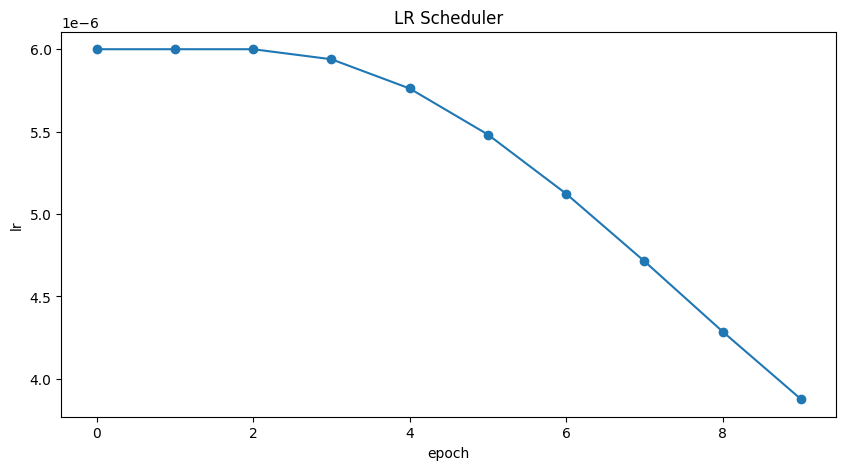

<class 'keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler'>


In [18]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)
print(type(lr_cb))


In [19]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_weighted_kappa",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
)


In [20]:
class WeightedKappa(keras.metrics.Metric):
    def __init__(self, num_classes=6, epsilon=1e-6):
        super().__init__(name="weighted_kappa")
        self.num_classes = num_classes
        self.epsilon = epsilon

        label_vec = keras.ops.arange(num_classes, dtype=keras.backend.floatx())
        self.row_label_vec = keras.ops.reshape(label_vec, [1, num_classes])
        self.col_label_vec = keras.ops.reshape(label_vec, [num_classes, 1])
        col_mat = keras.ops.tile(self.col_label_vec, [1, num_classes])
        row_mat = keras.ops.tile(self.row_label_vec, [num_classes, 1])
        self.weight_mat = (col_mat - row_mat) ** 2

        self.numerator = self.add_weight(name="numerator", initializer="zeros")
        self.denominator = self.add_weight(name="denominator", initializer="zeros")
        self.o_sum = self.add_weight(name="o_sum", initializer="zeros")
        self.e_sum = self.add_weight(name="e_sum", initializer="zeros")

    def update_state(self, y_true, y_pred, **args):
        # revert ordinal regression labels to classification labels
        y_true = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_true, dtype="int8"), axis=-1) - 1, 6
        )
        y_pred = keras.ops.one_hot(
            keras.ops.sum(keras.ops.cast(y_pred > 0.5, dtype="int8"), axis=-1) - 1, 6
        )
        # weighted kappa calculation
        y_true = keras.ops.cast(y_true, dtype=self.col_label_vec.dtype)
        y_pred = keras.ops.cast(y_pred, dtype=self.weight_mat.dtype)
        batch_size = keras.ops.shape(y_true)[0]

        cat_labels = keras.ops.matmul(y_true, self.col_label_vec)
        cat_label_mat = keras.ops.tile(cat_labels, [1, self.num_classes])
        row_label_mat = keras.ops.tile(self.row_label_vec, [batch_size, 1])

        weight = (cat_label_mat - row_label_mat) ** 2

        self.numerator.assign_add(keras.ops.sum(weight * y_pred))
        label_dist = keras.ops.sum(y_true, axis=0, keepdims=True)
        pred_dist = keras.ops.sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = keras.ops.matmul(
            self.weight_mat, keras.ops.transpose(pred_dist, [1, 0])
        )
        self.denominator.assign_add(
            keras.ops.sum(keras.ops.matmul(label_dist, w_pred_dist))
        )

        self.o_sum.assign_add(keras.ops.sum(y_pred))
        self.e_sum.assign_add(
            keras.ops.sum(
                keras.ops.matmul(keras.ops.transpose(label_dist, [1, 0]), pred_dist)
            )
        )

    def result(self):
        return 1.0 - (
            keras.ops.divide_no_nan(self.numerator, self.denominator)
            * keras.ops.divide_no_nan(self.e_sum, self.o_sum)
        )

    def reset_state(self):
        self.numerator.assign(0)
        self.denominator.assign(0)
        self.o_sum.assign(0)
        self.e_sum.assign(0)


# 🤖 | Modeling



In [21]:
# Create a BertClassifier model
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    CFG.preset, preprocessor=None, num_classes=6
)
inputs = classifier.input
logits = classifier(inputs)

print(type(logits), logits.shape)


# Compute final output
outputs = keras.layers.Activation("sigmoid")(logits)

# Build Model
model = keras.Model(inputs, outputs)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(3e-6),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        WeightedKappa()
    ],
)
model.summary()



<class 'keras.src.backend.common.keras_tensor.KerasTensor'> (None, 6)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_classif… │ (None, 6)         │ 184,426,7… │ padding_mask[0][… │
│ (DebertaV3Classifi… │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6)         │          0 │ deberta_v3_class… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,426,758 (703.53 MB)

 Trainable params: 184,426,758 (703.53 MB)

 Non-trainable params: 0 (0.00 B)

# 🚂 | Training

Following code will train the model on the training dataset and evaluate on the validation dataset.

In [22]:
# Start training the model
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[ckpt_cb]
)

Epoch 1/10


I0000 00:00:1734635313.509805    7247 service.cc:145] XLA service 0x7f18dc003050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734635313.509882    7247 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-20 03:08:35.278398: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-20 03:08:40.047503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1734635365.564227    7524 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_743', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734635367.161436    7568 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_562', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734

## Result Summary


================= ALL RESULTS =================
Epoch 1: Loss = 0.185, val Weighted Kappa = 0.582
Epoch 2: Loss = 0.171, val Weighted Kappa = 0.612
Epoch 3: Loss = 0.163, val Weighted Kappa = 0.620
Epoch 4: Loss = 0.158, val Weighted Kappa = 0.638
Epoch 5: Loss = 0.160, val Weighted Kappa = 0.640
Epoch 6: Loss = 0.165, val Weighted Kappa = 0.651
Epoch 7: Loss = 0.188, val Weighted Kappa = 0.609
Epoch 8: Loss = 0.188, val Weighted Kappa = 0.628
Epoch 9: Loss = 0.201, val Weighted Kappa = 0.620
Epoch 10: Loss = 0.222, val Weighted Kappa = 0.613


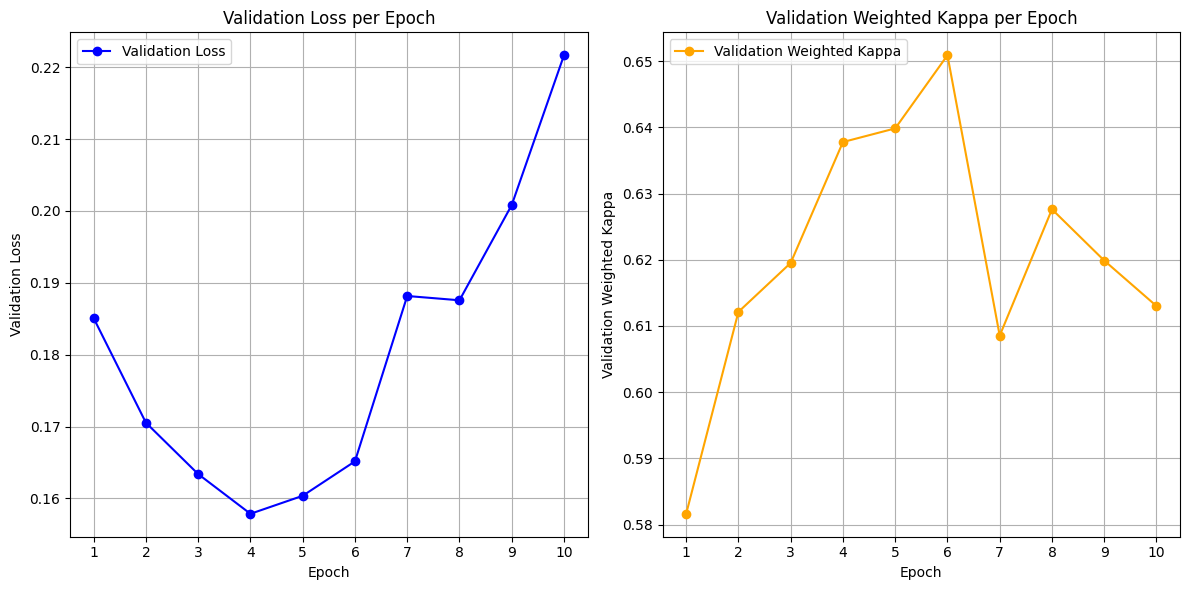

In [23]:
import numpy as np
import csv

# 获取所有 epoch 的分数和损失
epochs = range(1, len(history.history['val_weighted_kappa']) + 1)
val_kappas = history.history['val_weighted_kappa']
val_losses = history.history['val_loss']

# 打开 CSV 文件以便写入
with open('DebertaV3_base_en_val.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Validation Loss', 'Validation Weighted Kappa'])

    # 写入每个 epoch 的结果
    for epoch, val_loss, val_kappa in zip(epochs, val_losses, val_kappas):
        writer.writerow([epoch, val_loss, val_kappa])

# 打印所有结果
print(f'\n{"=" * 17} ALL RESULTS {"=" * 17}')
for epoch, val_loss, val_kappa in zip(epochs, val_losses, val_kappas):
    print(f'Epoch {epoch}: Loss = {val_loss:.3f}, val Weighted Kappa = {val_kappa:.3f}')
print('=' * 50)

# 可视化结果
plt.figure(figsize=(12, 6))

# 绘制验证损失
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, marker='o', color='blue', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(epochs)
plt.grid()
plt.legend()

# 绘制验证加权Kappa
plt.subplot(1, 2, 2)
plt.plot(epochs, val_kappas, marker='o', color='orange', label='Validation Weighted Kappa')
plt.title('Validation Weighted Kappa per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Weighted Kappa')
plt.xticks(epochs)
plt.grid()
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()


# 🧪 | Testing

In this section, we will visually test how our model performs on some samples from the validation data.

> Note that we are converting the ordinal regression model outputs with `sum`, unlike a typical classification problem where we would use `argmax`.

In [ ]:
# Load best checkpoint
model.load_weights("best_model.weights.h5")

# Make predictions using the trained model on last validation data
valid_preds = model.predict(valid_ds, verbose=0)

# Format predictions and true answers
pred_scores = np.sum((valid_preds > 0.5).astype(int), axis=-1)
true_scores = valid_df.score.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.full_text
    pred_answer = pred_scores[i]
    true_answer = true_scores[i]
    print(f"❓ Text {i+1}:\n{text[:150]} .... {text[-150:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-" * 90, "\n")


# 📬 | Submission

In this section, we will infer our model on the test data and then finally prepare the submission file.

## Build Test Dataset

In [100]:
# # Train Data
test_df = pd.read_csv(f"{BASE_PATH}/test.csv")
test_texts = test_df.full_text.fillna("").tolist()  # Extract training texts

# Build training dataset
test_ds = build_dataset(
    test_texts,
    labels=None,
    batch_size=min(CFG.batch_size, len(test_df)),
    shuffle=False,
    drop_remainder=False,  # include all samples
)


## Inference on Test Data

In [101]:
# Do inference
test_preds = model.predict(test_ds, verbose=1)

# Convert probabilities to class labels
test_preds = np.sum((test_preds>0.5).astype(int), axis=-1).clip(1, 6)

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

I0000 00:00:1734602970.256199   17739 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_33', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1734602973.823965   17641 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7', 16 bytes spill stores, 16 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 11s/step


## Create Submission File

In [102]:
# Create a DataFrame to store the submission
sub_df = test_df[["essay_id"]].copy()

# Add the formatted predictions to the submission DataFrame
sub_df["score"] = test_preds

# Save Submission
sub_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
sub_df.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,5


# ✍️ | Reference
* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte